In [168]:
import os
import random
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
#loading Metacritic dataset
metacritic = pd.read_csv(r'\metacritic.csv')

#loading sentimentscores
sentimentscores = pd.read_csv(r'\analysis\multiplayer_model\mp_sentiment_analyses\mp_sentiscores_userreviews.csv')

#Loading Innovativeness scores
innovativenesscores = pd.read_csv(r'\analysis\multiplayer_model\mp_innovativeness_analysis\mp_innovativeness_score_userreviews.csv')

#Loading Metacritic dataset LDA-analysis
data = pd.read_csv(r'\metacritic.csv')

#Loading VGChartz videogame sales
sales_data = pd.read_csv(r'\vgchartz.csv')

# Cleaning of User Reviews

In [169]:
metacritic.columns

Index(['Game', 'Metascore', 'UserScore', 'Publisher', 'ReleaseDate', 'Genre',
       'NumberOfOnlinePlayers', 'Cast', 'Credits', 'CriticsReviews',
       'UserReviews'],
      dtype='object')

In [170]:
#making an array with all online multiplayer elements
array = ['OnlineMultiplayer', 'MassivelyMultiplayerOnlineMultiplayer', 'OnlineMultiplayerUpto8Players','2PlayersOnlineMultiplayer', 'OnlineMultiplayerUpto4Players', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy,Action,General,General', 'BroadbandOnlyOnlineSystemLink', 'LiveAwareOnlineSystemLink', 'BroadbandOnlyOnline', 'Online', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto16Players', 'OnlineMultiplayerUpto18Players', 'BroadbandOnlyLiveAwareOnline', 'Role-PlayingMassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy,Fantasy', 'Role-Playing,ActionAdventure,Fantasy,MassivelyMultiplayerOnline,General,Fantasy,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,ActionRPG,MassivelyMultiplayer,Fantasy,Fantasy', 'MassivelyMultiplayerOnline,Role-Playing,Sci-Fi,Action,Shooter,Shooter,Third-Person,Sci-Fi,Sci-Fi,Arcade', 'OnlineMultiplayerUpto22Players', 'OnlineMultiplayerUpto30Players', 'OnlineMultiplayerUpto60Players'
'OnlineMultiplayerUpto6Players', 'Fantasy,Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto3Players', 'OnlineMultiplayerUpto64Players', 'OnlineMultiplayerUpto10Players', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Sci-Fi,Sci-Fi', 'OnlineMultiplayerUpto32Players']


In [171]:
#selecting all rows with array elements
metacritic = metacritic.loc[data['NumberOfOnlinePlayers'].isin(array)]

In [172]:
#validation on null data and NaNs in dataset
print(metacritic['NumberOfOnlinePlayers'].isnull().sum())
print(metacritic['NumberOfOnlinePlayers'].isna().sum())

0
0


In [173]:
#Drop NAN
metacritic = metacritic[metacritic['UserReviews'].notna()]

In [174]:
#Check dataset
metacritic['UserReviews']

140      [{'UserName': None, 'UserReviewScore': '90', '...
225      [{'UserName': None, 'UserReviewScore': '65', '...
255      [{'UserName': None, 'UserReviewScore': '70', '...
308      [{'UserName': None, 'UserReviewScore': '20', '...
352      [{'UserName': None, 'UserReviewScore': '50', '...
                               ...                        
49201    [{'UserName': None, 'UserReviewScore': '70', '...
49332    [{'UserName': None, 'UserReviewScore': '80', '...
49441    [{'UserName': None, 'UserReviewScore': '65', '...
49623    [{'UserName': None, 'UserReviewScore': '75', '...
49742    [{'UserName': None, 'UserReviewScore': '82', '...
Name: UserReviews, Length: 302, dtype: object

In [175]:
#Lower case reviews
metacritic['UserReviews'] = metacritic['UserReviews'].str.lower()

In [176]:
#Remove stopwords
stop = stopwords.words('english')
metacritic['UserReviews'] = metacritic['UserReviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [177]:
#Create new dataset
sentiment_data = metacritic[['Game', 'UserReviews']]
sentiment_data

,Game,UserReviews
140,Timespinner,"[{'username': none, 'userreviewscore': '90', '..."
225,Black Paradox,"[{'username': none, 'userreviewscore': '65', '..."
255,Redout,"[{'username': none, 'userreviewscore': '70', '..."
308,Happy Words,"[{'username': none, 'userreviewscore': '20', '..."
352,Warlocks 2: God Slayers,"[{'username': none, 'userreviewscore': '50', '..."
...,...,...
49201,Age of Wonders: Planetfall,"[{'username': none, 'userreviewscore': '70', '..."
49332,No Man's Sky Beyond,"[{'username': none, 'userreviewscore': '80', '..."
49441,Remnant: From the Ashes,"[{'username': none, 'userreviewscore': '65', '..."
49623,Acron: Attack of the Squirrels!,"[{'username': none, 'userreviewscore': '75', '..."


In [178]:
#Split reviews into rows
sentiment_data = sentiment_data.drop('UserReviews', axis=1).join(sentiment_data['UserReviews'].str.split(']', expand=True).stack().reset_index(level=1, drop=True).rename('UserReviews'))

In [179]:
#Drop columns with NaN
sentiment_data['UserReviews'] = sentiment_data['UserReviews'].dropna()

In [180]:
#Drop empty columns
sentiment_data = sentiment_data[sentiment_data.UserReviews != '']

In [181]:
#Check dataset
sentiment_data

,Game,UserReviews
140,Timespinner,"[{'username': none, 'userreviewscore': '90', '..."
225,Black Paradox,"[{'username': none, 'userreviewscore': '65', '..."
255,Redout,"[{'username': none, 'userreviewscore': '70', '..."
308,Happy Words,"[{'username': none, 'userreviewscore': '20', '..."
352,Warlocks 2: God Slayers,"[{'username': none, 'userreviewscore': '50', '..."
...,...,...
49201,Age of Wonders: Planetfall,"[{'username': none, 'userreviewscore': '70', '..."
49332,No Man's Sky Beyond,"[{'username': none, 'userreviewscore': '80', '..."
49441,Remnant: From the Ashes,"[{'username': none, 'userreviewscore': '65', '..."
49623,Acron: Attack of the Squirrels!,"[{'username': none, 'userreviewscore': '75', '..."


In [182]:
#DATA ALREADY CREATED
#Create dataset for sentiment analysis
#sentiment_data.to_excel(r'C:\Users\B.R\Documents\HvA\Master_DDB\MP\multiplayer_model\mp_sentiment_analyses\mp_seperated_userreviews.xlsx')

In [183]:
sentimentscores.head()

,Game,Sum_containword,TotalNegative,TotalPositive,StdDev_ContainWord
0,20XX,0,4,4,0.079282
1,9th Dawn III: Shadow of Erthil,-11,16,10,0.148968
2,AFL Evolution 2,0,2,2,0.079290
3,AO International Tennis,0,2,2,0.079290
4,AO Tennis 2,-2,5,4,0.084090


# Innovativeness score

In [184]:
innovativenesscores.head()

,Game,Total_innovativeness,StdDev_innovativeness
0,20XX,0,0.000000
1,9th Dawn III: Shadow of Erthil,2,0.165521
2,AFL Evolution 2,0,0.000000
3,AO International Tennis,0,0.000000
4,AO Tennis 2,0,0.000000


# LDA Topic analysis

In [185]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\B.R\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [186]:
data.reset_index(inplace=True)
data.columns

Index(['index', 'Game', 'Metascore', 'UserScore', 'Publisher', 'ReleaseDate',
       'Genre', 'NumberOfOnlinePlayers', 'Cast', 'Credits', 'CriticsReviews',
       'UserReviews'],
      dtype='object')

In [187]:
#making an array with all online multiplayer elements
array = ['OnlineMultiplayer', 'MassivelyMultiplayerOnlineMultiplayer', 'OnlineMultiplayerUpto8Players','2PlayersOnlineMultiplayer', 'OnlineMultiplayerUpto4Players', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy,Action,General,General', 'BroadbandOnlyOnlineSystemLink', 'LiveAwareOnlineSystemLink', 'BroadbandOnlyOnline', 'Online', 'Role-Playing,MassivelyMultiplayerOnline,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto16Players', 'OnlineMultiplayerUpto18Players', 'BroadbandOnlyLiveAwareOnline', 'Role-PlayingMassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy,Fantasy', 'Role-Playing,ActionAdventure,Fantasy,MassivelyMultiplayerOnline,General,Fantasy,Fantasy', 'Role-Playing,MassivelyMultiplayerOnline,ActionRPG,MassivelyMultiplayer,Fantasy,Fantasy', 'MassivelyMultiplayerOnline,Role-Playing,Sci-Fi,Action,Shooter,Shooter,Third-Person,Sci-Fi,Sci-Fi,Arcade', 'OnlineMultiplayerUpto22Players', 'OnlineMultiplayerUpto30Players', 'OnlineMultiplayerUpto60Players'
'OnlineMultiplayerUpto6Players', 'Fantasy,Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Fantasy', 'OnlineMultiplayerUpto3Players', 'OnlineMultiplayerUpto64Players', 'OnlineMultiplayerUpto10Players', 'Role-Playing,MassivelyMultiplayerOnline,MassivelyMultiplayer,Sci-Fi,Sci-Fi', 'OnlineMultiplayerUpto32Players']

#selecting all rows with array elements
data = data.loc[data['NumberOfOnlinePlayers'].isin(array)]

In [188]:
# let's see how many na values we have
print(data['UserReviews'].isnull().sum())
print(data['UserReviews'].isna().sum())
# we drop the rows that we don't need
data = data[data['UserReviews'].notna()]

155
155


In [189]:
# make sure all data is clean and ready to work on
print(data['UserReviews'].isnull().sum())
print(data['UserReviews'].isna().sum())

0
0


In [190]:
#Split reviews column into seperate rows
import json
reviews = pd.DataFrame()
for index, row in data.iterrows():
    print(index)
    critic = row['UserReviews']
    critic = critic.replace("\'", "\"")
    critic = critic.replace("\'None\'", "")
    critic = critic.replace('None,', "\"\",")
    try:
      j = json.loads(critic)
    except Exception as msg:
      print("**INEXCEPT")
      reviews = reviews.append({'index': row['index']}, ignore_index=True)
      continue
    j[0]['index'] = row['index']
    dataframe = pd.DataFrame.from_dict(j, orient="columns")
    reviews = reviews.append(dataframe, ignore_index=False)

140
225
255
308
352
393
394
466
516
524
542
603
622
640
646
684
742
856
863
889
1043
1057
1082
1333
1742
1751
2029
2339
2496
2615
2638
2887
5081
5122
6566
6718
6759
8392
8654
9649
9676
9875
12146
12504
13721
13812
13890
14222
14259
14260
14264
14288
14308
14352
14362
14387
14395
14474
14481
14516
14560
14606
14637
14703
14742
14775
14828
14886
14911
14919
14924
14944
14984
15000
15015
15023
15027
15032
15101
15155
15286
15289
15293
**INEXCEPT
15427
15436
15445
15540
15549
15591
15649
15685
15805
15861
16254
16313
16384
16920
**INEXCEPT
18117
18675
18986
20506
20511
20512
20517
20530
22390
22396
22439
22455
22482
22483
22695
22805
22827
22877
22878
22909
22978
23176
23222
23225
23308
23331
23335
23343
23344
23346
23369
23386
23424
23426
23435
23449
23472
23482
23500
23571
23574
23610
23614
23649
23764
23826
23827
23875
23884
23925
23927
24043
24055
24075
24078
24133
24147
24158
24178
24203
24209
24343
24389
24445
24520
24546
24770
24786
24814
24905
25025
25033
25053
25205
25233
25259
25

In [191]:
df = pd.merge(reviews, data, on='index', how='outer')
df.head()

,UserName,UserReviewScore,UserReviewDate,UserReviewText,ExpandedUserReviewText,TotalThumbsUp,TotalThumbs,index,Game,Metascore,UserScore,Publisher,ReleaseDate,Genre,NumberOfOnlinePlayers,Cast,Credits,CriticsReviews,UserReviews
0,,90,"Apr 28, 2020",,None,2,2,140.0,Timespinner,84.0,7.3,Chucklefish,"Jun 4, 2019","Action,Platformer,2D",OnlineMultiplayer,NaN,NaN,"[{'CriticName': 'NF Magazine', 'CriticScore': ...","[{'UserName': None, 'UserReviewScore': '90', '..."
1,,65,"May 6, 2020","I enjoyed so much, really like the context and...",None,4,5,225.0,Black Paradox,NaN,7.2,Digerati Distribution,"May 3, 2019","Action,Shooter,Shoot-'Em-Up,Horizontal",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '75', 'Cr...","[{'UserName': None, 'UserReviewScore': '65', '..."
2,,70,"Jun 10, 2019",,None,0,5,255.0,Redout,70.0,7.2,Nicalis,"May 14, 2019","Racing,Arcade,Futuristic",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '76', 'Cr...","[{'UserName': None, 'UserReviewScore': '70', '..."
3,,20,"May 31, 2019",Confusing controls at first when no reason for...,None,0,0,308.0,Happy Words,NaN,NaN,LAN - GAMES EOOD,"May 29, 2019","Puzzle,Logic",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '20', 'Cr...","[{'UserName': None, 'UserReviewScore': '20', '..."
4,,50,"Apr 13, 2020",,None,1,1,352.0,Warlocks 2: God Slayers,59.0,5.9,Fat Dog Games,"Jun 7, 2019","Role-Playing,ActionRPG",OnlineMultiplayer,NaN,NaN,"[{'CriticName': None, 'CriticScore': '90', 'Cr...","[{'UserName': None, 'UserReviewScore': '50', '..."


In [192]:
data = df
data_text = data[['Game', 'UserReviewText', 'UserScore']]
data_text['index'] = data_text.index
documents = data_text

<ipython-input-192-2cb23fd5e45c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['index'] = data_text.index


In [193]:
len(documents)

302

In [194]:
documents[:5]

,Game,UserReviewText,UserScore,index
0,Timespinner,,7.3,0
1,Black Paradox,"I enjoyed so much, really like the context and...",7.2,1
2,Redout,,7.2,2
3,Happy Words,Confusing controls at first when no reason for...,NaN,3
4,Warlocks 2: God Slayers,,5.9,4


## Data Pre-processing

### Lemmatize example

In [195]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


### Stemmer Example

In [196]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [197]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [198]:
documents

,Game,UserReviewText,UserScore,index
0,Timespinner,,7.3,0
1,Black Paradox,"I enjoyed so much, really like the context and...",7.2,1
2,Redout,,7.2,2
3,Happy Words,Confusing controls at first when no reason for...,NaN,3
4,Warlocks 2: God Slayers,,5.9,4
...,...,...,...,...
297,Age of Wonders: Planetfall,,NaN,297
298,No Man's Sky Beyond,NMS has finally reached the point that it is w...,NaN,298
299,Remnant: From the Ashes,,6.7,299
300,Acron: Attack of the Squirrels!,None,NaN,300


In [199]:
doc_sample = documents[documents['index'] == 299].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Remnant:', 'From', 'the', 'Ashes']


 tokenized and lemmatized document: 
['remnant', 'ash']


In [200]:
#delete empty rows
documents = documents[documents.UserReviewText != '']

In [201]:
processed_docs = documents['UserReviewText'].astype(str).map(preprocess)

In [202]:
processed_docs[:10]

1     [enjoy, like, context, idea, one, perfect, cha...
3     [confus, control, reason, advertis, local, onl...
7                                                    []
8        [pretti, basic, platform, overal, world, huge]
9                                                    []
10                                                   []
11    [nintento, version, good, want, content, game,...
12                                                   []
14                                                   []
15    [excelent, port, bien, conectado, tele, portát...
Name: UserReviewText, dtype: object

## Bag of words on the dataset

In [203]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [204]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 charact
1 context
2 enjoy
3 idea
4 like
5 movi
6 one
7 perfect
8 advertis
9 confus
10 consol


In [205]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [206]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[140]

[(0, 2), (1, 1)]

In [207]:
bow_doc_299 = bow_corpus[140]

for i in range(len(bow_doc_299)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_299[i][0], 
                                                     dictionary[bow_doc_299[i][0]], 
                                                     bow_doc_299[i][1]))

Word 0 ("game") appears 2 time.
Word 1 ("good") appears 1 time.


## TF-IDF

In [208]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [209]:
corpus_tfidf = tfidf[bow_corpus]

In [210]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[]


## Running LDA using TF-IDF

In [211]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [212]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.514*"play" + 0.250*"great" + 0.221*"game" + 0.015*"good"
Topic: 1 
Words: 0.540*"game" + 0.308*"good" + 0.076*"play" + 0.076*"great"
Topic: 2 
Words: 0.700*"play" + 0.278*"game" + 0.011*"good" + 0.011*"great"
Topic: 3 
Words: 0.507*"game" + 0.219*"good" + 0.178*"great" + 0.096*"play"
Topic: 4 
Words: 0.369*"play" + 0.329*"great" + 0.224*"good" + 0.078*"game"
Topic: 5 
Words: 0.472*"game" + 0.471*"great" + 0.030*"good" + 0.027*"play"
Topic: 6 
Words: 0.705*"game" + 0.271*"play" + 0.016*"great" + 0.009*"good"
Topic: 7 
Words: 0.751*"game" + 0.132*"play" + 0.109*"great" + 0.008*"good"
Topic: 8 
Words: 0.523*"good" + 0.470*"game" + 0.003*"play" + 0.003*"great"
Topic: 9 
Words: 0.846*"game" + 0.082*"good" + 0.067*"play" + 0.005*"great"


## Performance evaluation by classifying sample document using LDA Bag of Words model

In [213]:
processed_docs[140]

['perfect',
 'own',
 'play',
 'consol',
 'mario',
 'parti',
 'best',
 'access',
 'graphic',
 'gorgeous',
 'mini',
 'game',
 'great',
 'stellar',
 'one',
 'littl',
 'lot',
 'laugh',
 'room']

In [214]:
for index, score in sorted(lda_model[bow_corpus[140]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7749473452568054	 
Topic: 0.523*"good" + 0.470*"game" + 0.003*"play" + 0.003*"great"

Score: 0.02501123771071434	 
Topic: 0.846*"game" + 0.082*"good" + 0.067*"play" + 0.005*"great"

Score: 0.025009173899888992	 
Topic: 0.751*"game" + 0.132*"play" + 0.109*"great" + 0.008*"good"

Score: 0.02500869333744049	 
Topic: 0.705*"game" + 0.271*"play" + 0.016*"great" + 0.009*"good"

Score: 0.025006776675581932	 
Topic: 0.507*"game" + 0.219*"good" + 0.178*"great" + 0.096*"play"

Score: 0.025005754083395004	 
Topic: 0.472*"game" + 0.471*"great" + 0.030*"good" + 0.027*"play"

Score: 0.025004897266626358	 
Topic: 0.540*"game" + 0.308*"good" + 0.076*"play" + 0.076*"great"

Score: 0.025002935901284218	 
Topic: 0.700*"play" + 0.278*"game" + 0.011*"good" + 0.011*"great"

Score: 0.025002023205161095	 
Topic: 0.514*"play" + 0.250*"great" + 0.221*"game" + 0.015*"good"

Score: 0.025001194328069687	 
Topic: 0.369*"play" + 0.329*"great" + 0.224*"good" + 0.078*"game"


## Testing model on unseen document

In [215]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.10000000149011612	 Topic: 0.514*"play" + 0.250*"great" + 0.221*"game" + 0.015*"good"
Score: 0.10000000149011612	 Topic: 0.540*"game" + 0.308*"good" + 0.076*"play" + 0.076*"great"
Score: 0.10000000149011612	 Topic: 0.700*"play" + 0.278*"game" + 0.011*"good" + 0.011*"great"
Score: 0.10000000149011612	 Topic: 0.507*"game" + 0.219*"good" + 0.178*"great" + 0.096*"play"
Score: 0.10000000149011612	 Topic: 0.369*"play" + 0.329*"great" + 0.224*"good" + 0.078*"game"
Score: 0.10000000149011612	 Topic: 0.472*"game" + 0.471*"great" + 0.030*"good" + 0.027*"play"
Score: 0.10000000149011612	 Topic: 0.705*"game" + 0.271*"play" + 0.016*"great" + 0.009*"good"
Score: 0.10000000149011612	 Topic: 0.751*"game" + 0.132*"play" + 0.109*"great" + 0.008*"good"
Score: 0.10000000149011612	 Topic: 0.523*"good" + 0.470*"game" + 0.003*"play" + 0.003*"great"
Score: 0.10000000149011612	 Topic: 0.846*"game" + 0.082*"good" + 0.067*"play" + 0.005*"great"


## Identifying the most dominant topic within reviews

In [216]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=documents['UserReviewText']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [217]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=documents['UserReviewText'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1000,"play, great, game, good",NaN
1,1,9.0,0.7750,"game, good, play, great","I enjoyed so much, really like the context and..."
2,2,0.0,0.1000,"play, great, game, good",NaN
3,3,0.0,0.1000,"play, great, game, good",Confusing controls at first when no reason for...
4,4,0.0,0.1000,"play, great, game, good",NaN
5,5,0.0,0.1000,"play, great, game, good",NaN
6,6,8.0,0.6999,"good, game, play, great",NaN
7,7,0.0,0.1000,"play, great, game, good",None
8,8,0.0,0.1000,"play, great, game, good","Pretty basic platformer, but the overall world..."
9,9,0.0,0.1000,"play, great, game, good",None


# Merging data analysis outcome

In [218]:
sales_data.head()

,Game,Platform,Publisher,VGChartzScore,CriticScore,TotalSales,ReleaseDate,LastUpdate
0,Grand Theft Auto: Liberty City Stories,PSP,Rockstar Games,N/A,8.8,7.72m,25th Oct 05,NaN
1,Grand Theft Auto: Vice City Stories,PSP,Rockstar Games,N/A,8.4,5.08m,31st Oct 06,NaN
2,Monster Hunter Freedom 3,PSP,Capcom,N/A,N/A,4.87m,01st Dec 10,08th Jan 19
3,Gran Turismo,PSP,Sony Computer Entertainment,7.5,7.7,2.93m,01st Oct 09,NaN
4,Monster Hunter Freedom Unite,PSP,Capcom,N/A,7.7,5.50m,23rd Jun 09,NaN


In [219]:
#merging sales data with metacritic reviews
merge_sales = pd.merge(documents, sales_data, on='Game', how='left')

In [220]:
#merging topic dominance scores
topicsales = merge_sales.merge(df_dominant_topic, left_index=True, right_index=True)

In [221]:
#merging sentimentscores
sentisales = pd.merge(topicsales, sentimentscores, on='Game', how='left')

In [222]:
#merging innovativeness scores
finaldata = pd.merge(innovativenesscores, sentisales, on='Game', how='left')

In [223]:
#Drop NaNs for the regression
finaldata.dropna(subset = ['StdDev_ContainWord', 'StdDev_innovativeness', 'Topic_Perc_Contrib', 'UserScore', 'TotalSales'], inplace=True)

In [224]:
#Removing letter M from sales
finaldata['TotalSales'] = finaldata['TotalSales'].map(lambda x: x.rstrip('m'))

In [225]:
#validation on null data and NaNs in dataset
print(finaldata[['StdDev_ContainWord', 'StdDev_innovativeness', 'Topic_Perc_Contrib', 'UserScore', 'TotalSales']].isnull().sum())
print(finaldata[['StdDev_ContainWord', 'StdDev_innovativeness', 'Topic_Perc_Contrib', 'UserScore', 'TotalSales']].isna().sum())

StdDev_ContainWord       0
StdDev_innovativeness    0
Topic_Perc_Contrib       0
UserScore                0
TotalSales               0
dtype: int64
StdDev_ContainWord       0
StdDev_innovativeness    0
Topic_Perc_Contrib       0
UserScore                0
TotalSales               0
dtype: int64


In [226]:
finaldata.head()

,Game,Total_innovativeness,StdDev_innovativeness,UserReviewText,UserScore,index,Platform,Publisher,VGChartzScore,CriticScore,...,LastUpdate,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Sum_containword,TotalNegative,TotalPositive,StdDev_ContainWord
33,Blade Strangers,0,0.0,"Looks awful, plays awful, the speed is really ...",6.0,172.0,NS,Nicalis,7.0,8.3,...,28th Jul 18,65.0,2.0,0.6999,"play, game, good, great",NaN,-8.0,10.0,10.0,0.132950
54,Dark Souls Trilogy,0,0.0,The other best fantasy series in video game hi...,7.2,177.0,XOne,Namco Bandai,N/A,N/A,...,24th Aug 18,67.0,5.0,0.6999,"game, great, good, play",NaN,5.0,3.0,5.0,0.120559
73,Earthfall,0,0.0,"Given the poor reviews, I’ve been very pleasan...",5.6,168.0,XOne,Gearbox Software,N/A,N/A,...,25th May 18,63.0,9.0,0.6999,"game, good, play, great",NaN,4.0,9.0,11.0,0.135880
91,GRID,0,0.0,Really good job. Better than I expected. Con...,5.2,84.0,PS3,Codemasters,9.3,8.6,...,NaN,24.0,8.0,0.6999,"good, game, play, great","Betatester, please uninstall your self!",3.0,5.0,6.0,0.098104
198,Super Mario Party,0,0.0,"It s not perfect, but I ve owned and played al...",7.1,140.0,NS,Nintendo,7.0,7.3,...,19th Nov 18,47.0,0.0,0.4363,"play, great, game, good",NaN,10.0,4.0,10.0,0.156032


# Multivariate regression analysis


In [235]:
#define X and Y dependent and independent variables
X = finaldata[['StdDev_ContainWord', 'StdDev_innovativeness', 'Topic_Perc_Contrib', 'UserScore']].astype(float)
y = finaldata['TotalSales'].astype(float)

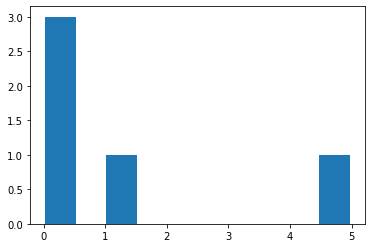

In [236]:
#check distribution of the data
plt.hist(y, bins=10)
plt.show()

In [237]:
#apply data tranformation with log transformation
y = np.log(y+1)

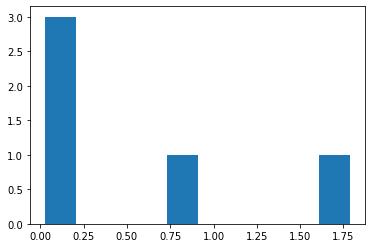

In [238]:
#check distribution of data again
plt.hist(y, bins=10)
plt.show()

In [239]:
#adding a constant (Y-intercept)
X = sm.add_constant(X)

In [240]:
#Checking multicolinearity variance inflation factor (VIF >5.0)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                 feature         VIF
0                  const  382.575899
1     StdDev_ContainWord    2.210143
2  StdDev_innovativeness         NaN
3     Topic_Perc_Contrib    2.213198
4              UserScore    1.540953
C:\Users\B.R\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [241]:
#define model
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

In [242]:
#print regression results
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             TotalSales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2532.
Date:                Thu, 17 Jun 2021   Prob (F-statistic):             0.0146
Time:                        16:34:58   Log-Likelihood:                 17.125
No. Observations:                   5   AIC:                            -26.25
Df Residuals:                       1   BIC:                            -27.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.40